In [76]:
import wandb
import matplotlib.pyplot as plt
import dice_ml
import warnings
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from dice_ml.explainer_interfaces.explainer_base import UserConfigValidationException
import plotly.graph_objects as go
from datetime import timedelta
from scripts.SEP_CFE_functions import *
from slim_tsf.func._slim_TSF import SlimTimeSeriesForestClassifier
from aeon.utils.numba.stats import row_mean
import re
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import dice_ml
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import seaborn as sns
import joblib
import os
from sklearn.preprocessing import MinMaxScaler
from scripts.SEP_CFE_functions import *
min_max_scaler = MinMaxScaler()
warnings.filterwarnings("ignore")

In [77]:
DATA_DIR = "/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/processed/"

In [78]:
train_df = pd.read_csv(DATA_DIR + "train_top20_rowmean.csv", sep=',')
test_df = pd.read_csv(DATA_DIR + "test_top20_rowmean.csv", sep=',')
val_df = pd.read_csv(DATA_DIR + "val_top20_rowmean.csv", sep=',')
combined_df = pd.read_csv(DATA_DIR + "combined_top20_rowmean_with_filelist.csv", sep=',')


In [79]:
X_train = train_df.drop(columns=['label'])
y_train = train_df['label']
X_test = test_df.drop(columns=['label'])
y_test = test_df['label']
X_val = val_df.drop(columns=['label'])
y_val = val_df['label']


In [80]:
print(X_train.head())

   long_mean_@[300:660]  long_mean_@[396:636]  long_mean_@[420:660]  \
0              0.000002              0.000002              0.000002   
1              0.000001              0.000001              0.000002   
2              0.000001              0.000001              0.000001   
3              0.000005              0.000002              0.000002   
4              0.000004              0.000004              0.000005   

   long_mean_@[480:660]  long_mean_@[540:660]  p3_flux_ic_mean_@[300:480]  \
0          1.843730e-06              0.000002                    0.129404   
1          1.744159e-06              0.000002                    0.126223   
2          9.902296e-07              0.000001                    0.152870   
3          1.425889e-06              0.000001                    0.669969   
4          5.386373e-06              0.000007                    0.193647   

   p3_flux_ic_mean_@[300:540]  p3_flux_ic_mean_@[300:660]  \
0                    0.128755                    

In [81]:

##Define the hyperparameter grid
# param_grid = {
#     'n_estimators': [50, 100, 200, 300, 400, 500],
#     'max_depth': [2, 3, 4, 5, 6, 7, 8]
# }
# rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
#
# # Define a stratified k-fold cross-validation strategy
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#
# # Define a scorer that focuses on the F1 score of the positive class (assumed to be label 1)
# scorer = make_scorer(f1_score, pos_label=1)
#
# # Setup GridSearchCV with the classifier, parameter grid, CV strategy, and scorer
# grid_search = GridSearchCV(estimator=rf_clf,
#                            param_grid=param_grid,
#                            cv=cv,
#                            scoring=scorer,
#                            n_jobs=-1,
#                            verbose=1)
#
# # Fit the grid search to the training data
# grid_search.fit(X_train, y_train)
#
# # Print the best hyperparameters and corresponding score from cross-validation
# print("Best parameters found:", grid_search.best_params_)
# print("Best F1 score (for positive class) from CV:", grid_search.best_score_)
#
# # Retrieve the best estimator and evaluate on the test data
# best_rf = grid_search.best_estimator_
# Y_pred = best_rf.predict(X_train)
#
# # Save model
# joblib.dump(best_rf, '/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/models/RandomForestClassifier_model_sep_on_reduced_data_cfe.pkl')
#
# # Output the test classification report and confusion matrix
# print("\nTest Classification Report:\n", classification_report(y_train, Y_pred))
# print("Test Confusion Matrix:\n", confusion_matrix(y_train, Y_pred))



In [82]:
best_rf = joblib.load('/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/models/RandomForestClassifier_model_sep_on_reduced_data_cfe.pkl')

In [83]:
overall_results = []
y_pred = best_rf.predict(X_train)
overall_results.append(('training set',accuracy_score(y_train, y_pred), TSS(y_train, y_pred), HSS(y_train, y_pred)))
Y_val_pred = best_rf.predict(X_val)
overall_results.append(('validation set',accuracy_score(y_val, Y_val_pred), TSS(y_val, Y_val_pred), HSS(y_val, Y_val_pred)))
Y_test_pred = best_rf.predict(X_test)
overall_results.append(('testing set',accuracy_score(y_test, Y_test_pred), TSS(y_test, Y_test_pred), HSS(y_test, Y_test_pred)))
print(pd.DataFrame(overall_results, columns=["Dataset", "accuracy", "TSS", "HSS"]))


          Dataset  accuracy       TSS       HSS
0    training set  0.976695  0.891358  0.855767
1  validation set  0.965461  0.784173  0.777251
2     testing set  0.948157  0.632377  0.652677


                       Feature  Importance
82  p3_flux_ic_mean_@[652:658]    0.089626
83  p3_flux_ic_mean_@[654:660]    0.069715
79  p3_flux_ic_mean_@[645:660]    0.053861
75  p3_flux_ic_mean_@[642:648]    0.050674
57  p3_flux_ic_mean_@[600:660]    0.049285
81  p3_flux_ic_mean_@[651:657]    0.046972
64  p3_flux_ic_mean_@[615:660]    0.042194
72  p3_flux_ic_mean_@[636:651]    0.039215
73  p3_flux_ic_mean_@[639:654]    0.037905
76  p3_flux_ic_mean_@[642:657]    0.036486
77  p3_flux_ic_mean_@[644:659]    0.036195
80  p3_flux_ic_mean_@[646:652]    0.035644
68  p3_flux_ic_mean_@[624:654]    0.028735
60  p3_flux_ic_mean_@[606:651]    0.021373
36  p3_flux_ic_mean_@[540:660]    0.020600
55  p3_flux_ic_mean_@[599:644]    0.020463
4         long_mean_@[540:660]    0.018654
3         long_mean_@[480:660]    0.017323
53  p3_flux_ic_mean_@[588:648]    0.015968
54  p3_flux_ic_mean_@[597:642]    0.014602


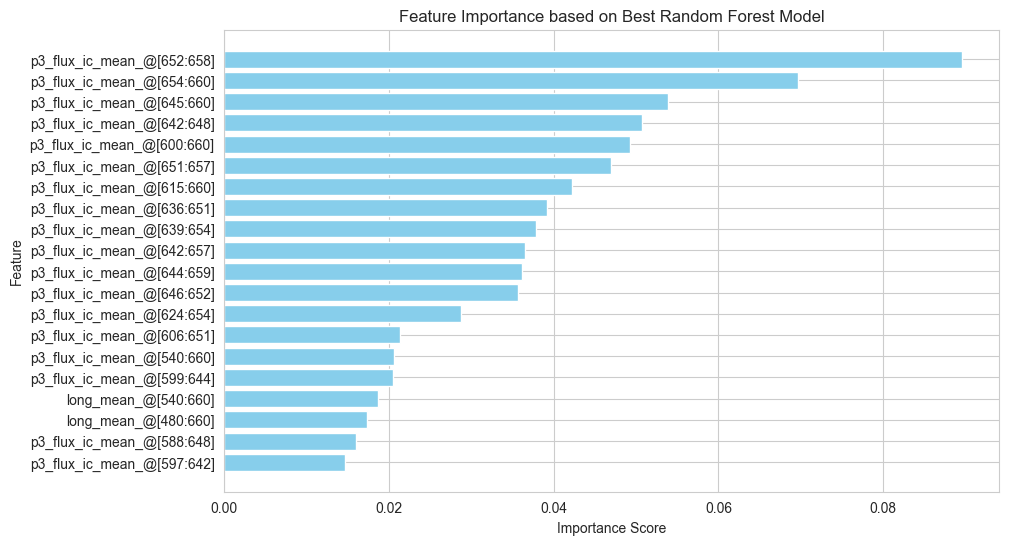

In [84]:
# Assuming `best_rf` is your trained Random Forest model
# and `X_train` contains the feature names

# Get feature importance scores
feature_importances = best_rf.feature_importances_

# Create a DataFrame to organize feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

# Display the top features
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance based on Best Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()


In [85]:
df_cfe = combined_df.drop(columns=['File']).copy()

#df_cfe = df_combined_labels.drop(["Label","File","Label.1"],axis=1)  # should contain the target column
cont_features = list(test_df.drop(["label"],axis=1).columns) #should not contain target column
# data= dice_ml.Data(dataframe=df_cfe, continuous_features=cont_features, outcome_name='label')
data= dice_ml.Data(dataframe=df_cfe, continuous_features=cont_features, outcome_name='Label')

In [86]:
# #Define a Model object using dice_ml.Model (we are using this CFE model for regressor type of prediction model
# cfe_model = dice_ml.Model(model=best_rf, backend="sklearn", model_type='classifier')
# #Create the Dice explainer
# exp_random = dice_ml.Dice(data_interface=data, model_interface=cfe_model, method="random") #method= ["genetic","kdtree","random"]
#
# # Save the explainer (DiCE model) using joblib
# joblib.dump(exp_random, "/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/models/sep_cfe_slim_tsf_random_explainer.pkl")
#
# #use `exp` to generate counterfactual explanations
# print("\nRandom Dice explainer created successfully.\n")

In [87]:
#Define a Model object using dice_ml.Model (we are using this CFE model for regressor type of prediction model
cfe_model = dice_ml.Model(model=best_rf, backend="sklearn", model_type='classifier')
#Create the Dice explainer
exp_genetic = dice_ml.Dice(data_interface=data, model_interface=cfe_model, method="genetic") #method= ["genetic","kdtree","random"]

# Save the explainer (DiCE model) using joblib
joblib.dump(exp_genetic, "/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/models/sep_cfe_slim_tsf_genetic_explainer_1.pkl")

#use `exp` to generate counterfactual explanations
print("\nGenetic Dice explainer created successfully.\n")


Genetic Dice explainer created successfully.



In [88]:
exp_random = joblib.load("/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/models/sep_cfe_slim_tsf_random_explainer.pkl")
exp_genetic = joblib.load("/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/models/sep_cfe_slim_tsf_genetic_explainer.pkl")

In [89]:
p3_flux_cols = [col for col in train_df.columns if 'p3_flux_ic_mean' in col]
p5_flux_cols = [col for col in train_df.columns if 'p5_flux_ic_mean' in col]
p7_flux_cols = [col for col in train_df.columns if 'p7_flux_ic_mean' in col]
long_cols = [col for col in train_df.columns if 'long_mean' in col]

In [90]:
def process_header_list(header_list):
    """
    Extracts metric intervals from header names like:
        p3_flux_ic_mean_@[300:660]
    Returns list of tuples: (metric, slice_str, start, end)
    """
    pattern = r'^(p3_flux_ic_mean|p5_flux_ic_mean|p7_flux_ic_mean|long_mean)_@\[(\d+):(\d+)\]$'
    result = []
    for col in header_list:
        m = re.match(pattern, col)
        if m:
            metric = m.group(1)
            start, end = int(m.group(2)), int(m.group(3))
            slice_str = f"{start}:{end}"
            result.append((metric, slice_str, start, end))
    return result


def build_interval_dataframe(header_list):
    """
    Builds a long-format DataFrame from a list of header names.

    Output columns:
        metric | slice | start | end
    """
    entries = process_header_list(header_list)
    df = pd.DataFrame(entries, columns=["metric", "slice", "start", "end"])
    df.sort_values(["metric", "start", "end"], inplace=True)
    return df


def extract_values(df, metric_name=None):
    """
    If metric_name is given, return all (start, end) pairs for that metric.
    If None, return a dictionary {metric: [(start, end), ...]} for all metrics.
    """
    if metric_name:
        filtered = df[df["metric"] == metric_name]
        return list(zip(filtered["start"], filtered["end"]))
    else:
        return {
            metric: list(zip(sub["start"], sub["end"]))
            for metric, sub in df.groupby("metric")
        }


header_list = train_df.columns.astype(str).str.cat(sep="\t").split()
print(header_list)

df_slices = build_interval_dataframe(header_list)
print("📘 Interval dataframe:\n", df_slices)

# # extract for one metric
# p3_slices = extract_values(df_slices, "p3_flux_ic_mean")
# print("\n🎯 P3 slices:\n", p3_slices)

# extract for all metrics
all_slices = extract_values(df_slices)
print("\n🌍 All metrics dictionary:\n", all_slices)


['long_mean_@[300:660]', 'long_mean_@[396:636]', 'long_mean_@[420:660]', 'long_mean_@[480:660]', 'long_mean_@[540:660]', 'p3_flux_ic_mean_@[300:480]', 'p3_flux_ic_mean_@[300:540]', 'p3_flux_ic_mean_@[300:660]', 'p3_flux_ic_mean_@[336:516]', 'p3_flux_ic_mean_@[348:588]', 'p3_flux_ic_mean_@[360:480]', 'p3_flux_ic_mean_@[372:552]', 'p3_flux_ic_mean_@[390:570]', 'p3_flux_ic_mean_@[396:636]', 'p3_flux_ic_mean_@[408:588]', 'p3_flux_ic_mean_@[420:540]', 'p3_flux_ic_mean_@[420:660]', 'p3_flux_ic_mean_@[435:525]', 'p3_flux_ic_mean_@[444:564]', 'p3_flux_ic_mean_@[444:624]', 'p3_flux_ic_mean_@[462:552]', 'p3_flux_ic_mean_@[468:588]', 'p3_flux_ic_mean_@[480:540]', 'p3_flux_ic_mean_@[480:570]', 'p3_flux_ic_mean_@[480:600]', 'p3_flux_ic_mean_@[480:660]', 'p3_flux_ic_mean_@[492:612]', 'p3_flux_ic_mean_@[498:588]', 'p3_flux_ic_mean_@[507:552]', 'p3_flux_ic_mean_@[510:570]', 'p3_flux_ic_mean_@[516:606]', 'p3_flux_ic_mean_@[516:636]', 'p3_flux_ic_mean_@[525:615]', 'p3_flux_ic_mean_@[530:575]', 'p3_flux_

In [91]:
len(all_slices)

4

In [92]:
def get_query_instance(query_ts_filename, df_combined_labels, model):
    """
    Retrieve the query instance and its target label for a given filename.

    Args:
           query_ts_filename (str): The filename identifying the query instance.
           df_combined_labels (pd.DataFrame): DataFrame containing labeled data.
           model: A trained classifier with a `.predict()` method.

    Returns:
        Tuple[pd.DataFrame, Any]: The query instance (features only) and its true label.
     """
    query_instance_raw = df_combined_labels[df_combined_labels['File'] == query_ts_filename]
    query_instance = query_instance_raw.drop(["Label","File"], axis=1)

    true_label = query_instance_raw["Label"].values[0]
    predicted_label = model.predict(query_instance)

    print("Target value for the query instance:\n", true_label)
    print("Predicted value:\n", predicted_label)

    return query_instance, true_label, predicted_label

In [112]:
import numpy as np
import pandas as pd
from datetime import timedelta
import re


def get_pertubed_series(
    csv_path,
    sample_cfe,
    flux_type,
    header_list,
    start_offset_min=300,
    end_offset_min=660,
):
    """
    Overlapping-window perturbation with SAFE interpolation:
    - Performs projection-based mean adjustment inside interval windows.
    - Applies linear interpolation ONLY to uncovered indices (outside windows).
    """

    # ---------------------------------------------------------
    # 1. Load CSV and slice event window
    # ---------------------------------------------------------
    df = pd.read_csv(csv_path, delimiter=",")
    df = df.rename(columns={"time_tag": "time_stamp"})
    df["time_stamp"] = pd.to_datetime(df["time_stamp"], errors="coerce")

    event_start = df["time_stamp"].iloc[0] + timedelta(minutes=start_offset_min)
    event_end   = df["time_stamp"].iloc[0] + timedelta(minutes=end_offset_min)

    df_obs = df[(df["time_stamp"] >= event_start) &
                (df["time_stamp"] < event_end)].copy()

    df_obs["minutes"] = (df_obs["time_stamp"] - event_start).dt.total_seconds() / 60

    x = df_obs[flux_type].to_numpy(dtype=float)
    n = len(x)

    if isinstance(sample_cfe, pd.DataFrame):
        sample_cfe = sample_cfe.iloc[0]

    # ---------------------------------------------------------
    # 2. Extract slice intervals for THIS flux_type
    # ---------------------------------------------------------
    pat = re.compile(rf"^{flux_type}_mean_@\[(\d+):(\d+)\]$")
    absolute_slices = []

    for col in header_list:
        m = pat.match(col)
        if m:
            absolute_slices.append((int(m.group(1)), int(m.group(2))))

    absolute_slices = sorted(set(absolute_slices))

    # ---------------------------------------------------------
    # 3. Convert absolute → local → index slices; Extract NEW means
    # ---------------------------------------------------------
    index_slices = []
    new_means = []

    for abs_start, abs_end in absolute_slices:

        local_start = abs_start - start_offset_min
        local_end   = abs_end   - start_offset_min

        mask = (df_obs["minutes"] >= local_start) & (df_obs["minutes"] < local_end)
        idx = np.where(mask)[0]

        if len(idx) == 0:
            continue

        index_slices.append((idx[0], idx[-1] + 1))

        col_name = f"{flux_type}_mean_@[{abs_start}:{abs_end}]"
        new_means.append(float(sample_cfe[col_name]))

    new_means = np.array(new_means)
    k = len(index_slices)

    # No slices → no perturbation
    if k == 0:
        return df_obs, pd.Series(x, index=df_obs.index), pd.Series(x, index=df_obs.index)

    # ---------------------------------------------------------
    # 4. Build overlapping-window A matrix
    # ---------------------------------------------------------
    A = np.zeros((k, n), dtype=float)
    for i, (s, e) in enumerate(index_slices):
        A[i, s:e] = 1.0 / (e - s)

    # ---------------------------------------------------------
    # 5. Projection: y = x - A^T (AA^T)^{-1} (Ax - new_means)
    # ---------------------------------------------------------
    Ax = A @ x
    AA_T_inv = np.linalg.inv(A @ A.T)

    correction = A.T @ (AA_T_inv @ (Ax - new_means))
    y = x - correction

    # ---------------------------------------------------------
    # 6. SAFE INTERPOLATION — ONLY outside covered windows
    # ---------------------------------------------------------
    # all indices inside windows
    covered_idx = sorted({i for s, e in index_slices for i in range(s, e)})

    # mask for uncovered indices
    mask_uncovered = np.ones(n, dtype=bool)
    mask_uncovered[covered_idx] = False

    # linear interpolation on FULL SERIES (temporary)
    interp_full = pd.Series(y).interpolate(method="linear").to_numpy()

    # but only apply interpolation on uncovered points
    y_filled = y.copy()
    y_filled[mask_uncovered] = interp_full[mask_uncovered]

    # ---------------------------------------------------------
    # 7. Return perturbed + original
    # ---------------------------------------------------------
    perturbed_series = pd.Series(y_filled, index=df_obs.index)
    original_series  = pd.Series(x, index=df_obs.index)

    return df_obs, perturbed_series, original_series


In [113]:
query_ts_filename = '2003-06-18_12-15.csv'
query_instance1, class_label, predicted_label = get_query_instance(query_ts_filename, combined_df, best_rf)

cfe_label = 0 if predicted_label[0] == 1 else 1

print(f"cfe_label: {cfe_label}")
cfe_exp = []
df_cfe_exp_genetic_1 = pd.DataFrame()
cfe_genetic = exp_genetic.generate_counterfactuals(
    query_instance1,  #multiple query instances can be provided as an input dataframe
    total_CFs=1,  # Number of counterfactual examples to generate
    desired_class=cfe_label,  #'opposite' #,  # Specify the desired class for a continuous target variable
    #permitted_range={'variable1': [20, 30], 'variable2': ['val1', 'val2']}
    # features_to_vary=top_k_features,
    # proximity_weight=pw,
    # diversity_weight=dw
    # feature_weights=sorted_normalized_weights_dict
)

cfe_genetic.visualize_as_dataframe(show_only_changes=True)
df_cfe_exp_genetic_1 = cfe_genetic.cf_examples_list[0].final_cfs_df


Target value for the query instance:
 1
Predicted value:
 [1]
cfe_label: 0


100%|██████████| 1/1 [00:00<00:00,  6.43it/s]

Query instance (original outcome : 1)


,long_mean_@[300:660],long_mean_@[396:636],long_mean_@[420:660],long_mean_@[480:660],long_mean_@[540:660],p3_flux_ic_mean_@[300:480],p3_flux_ic_mean_@[300:540],p3_flux_ic_mean_@[300:660],p3_flux_ic_mean_@[336:516],p3_flux_ic_mean_@[348:588],...,p5_flux_ic_mean_@[396:636],p5_flux_ic_mean_@[420:660],p5_flux_ic_mean_@[480:660],p5_flux_ic_mean_@[540:660],p5_flux_ic_mean_@[570:660],p5_flux_ic_mean_@[600:660],p7_flux_ic_mean_@[300:660],p7_flux_ic_mean_@[396:636],p7_flux_ic_mean_@[420:660],label
0,6.865437e-07,6.759881e-07,6.498988e-07,6.483254e-07,6.073215e-07,4.023111,4.469542,5.358861,4.213056,5.224608,...,0.060455,0.059797,0.057512,0.060251,0.054849,0.060245,0.021987,0.021026,0.021407,1



Diverse Counterfactual set (new outcome: 0)


,long_mean_@[300:660],long_mean_@[396:636],long_mean_@[420:660],long_mean_@[480:660],long_mean_@[540:660],p3_flux_ic_mean_@[300:480],p3_flux_ic_mean_@[300:540],p3_flux_ic_mean_@[300:660],p3_flux_ic_mean_@[336:516],p3_flux_ic_mean_@[348:588],...,p5_flux_ic_mean_@[396:636],p5_flux_ic_mean_@[420:660],p5_flux_ic_mean_@[480:660],p5_flux_ic_mean_@[540:660],p5_flux_ic_mean_@[570:660],p5_flux_ic_mean_@[600:660],p7_flux_ic_mean_@[300:660],p7_flux_ic_mean_@[396:636],p7_flux_ic_mean_@[420:660],label
0,3.375754e-06,2.450952e-06,2.189e-06,1.93294e-06,1.77333e-06,4.637610912,4.519666672,4.145833492,4.607089043,4.423741817,...,0.074,0.071,0.07,0.062,0.063,0.061,0.0292,0.0288,0.029,0.0


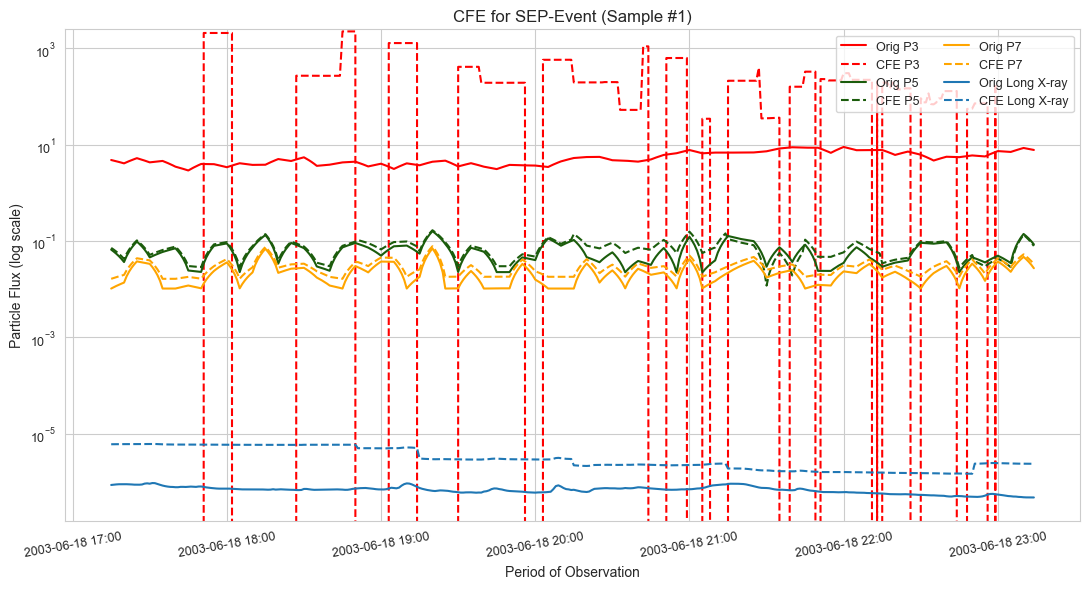

In [114]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import os

window_size = None
CSV_DATA_DIR = "/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/raw/data/"
csv_path = os.path.join(CSV_DATA_DIR, query_ts_filename)

# choose which counterfactual sample to plot
cfe_idx = 0
sample_cfe = df_cfe_exp_genetic_1.iloc[cfe_idx]

# --------------------------------------------------------
# Helper: get original + perturbed for one flux channel
# --------------------------------------------------------
def compute_flux_pair(flux_type):
    df_obs, cf_series, orig_series = get_pertubed_series(
        csv_path,
        sample_cfe,
        flux_type,
        header_list,
        300,
        660
    )
    # force to series
    cf_series = pd.Series(cf_series)
    orig_series = pd.Series(orig_series)
    return df_obs, orig_series, cf_series


# --------------------------------------------------------
# Compute all 4 flux channels
# --------------------------------------------------------
df_p3, orig_p3, cf_p3 = compute_flux_pair("p3_flux_ic")
df_p5, orig_p5, cf_p5 = compute_flux_pair("p5_flux_ic")
df_p7, orig_p7, cf_p7 = compute_flux_pair("p7_flux_ic")
df_l , orig_l , cf_l  = compute_flux_pair("long")

# for combined y-limits
all_min = min(orig_p3.min(), orig_p5.min(), orig_p7.min(), orig_l.min(),
              cf_p3.min(),  cf_p5.min(),  cf_p7.min(),  cf_l.min())
all_max = max(orig_p3.max(), orig_p5.max(), orig_p7.max(), orig_l.max(),
              cf_p3.max(),  cf_p5.max(),  cf_p7.max(),  cf_l.max())

# --------------------------------------------------------
# Plotting
# --------------------------------------------------------
fig, ax = plt.subplots(figsize=(11, 6), facecolor="white")
ax.set_facecolor("white")

# Plot each series
ax.plot(df_p3["time_stamp"], orig_p3, label="Orig P3", color="#FF0000")
ax.plot(df_p3["time_stamp"], cf_p3,   "--", label="CFE P3", color="#FF0000")

ax.plot(df_p5["time_stamp"], orig_p5, label="Orig P5", color="#1b5c0c")
ax.plot(df_p5["time_stamp"], cf_p5,   "--", label="CFE P5", color="#1b5c0c")

ax.plot(df_p7["time_stamp"], orig_p7, label="Orig P7", color="#FFA500")
ax.plot(df_p7["time_stamp"], cf_p7,   "--", label="CFE P7", color="#FFA500")

ax.plot(df_l["time_stamp"],  orig_l, label="Orig Long X-ray", color="#1f77b4")
ax.plot(df_l["time_stamp"],  cf_l,   "--", label="CFE Long X-ray", color="#1f77b4")

# log-scale + limits
ax.set_yscale("log")
ax.set_ylim(all_min * 0.9, all_max * 1.1)

# labels
ax.set_xlabel("Period of Observation", fontsize=10)
ax.set_ylabel("Particle Flux (log scale)", fontsize=10)

# datetime formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
plt.setp(ax.get_xticklabels(), rotation=10, ha="center", fontsize=9)
plt.setp(ax.get_yticklabels(), fontsize=9)

# title
label_str = "SEP-Event" if class_label == 1 else "Non-SEP event"
ax.set_title(f"CFE for {label_str} (Sample #{cfe_idx+1})", fontsize=12)

# legend
ax.legend(loc="upper right", fontsize=9, ncol=2, frameon=True)

plt.tight_layout()
plt.show()


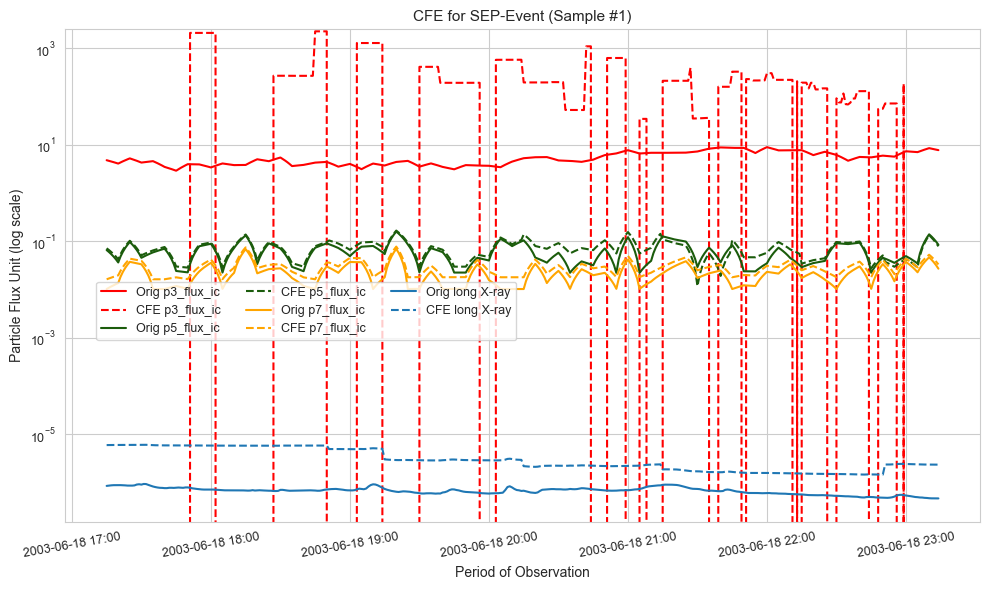

In [95]:
window_size = None
CSV_DATA_DIR = "/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/raw/data/"
csv_path = os.path.join(CSV_DATA_DIR, query_ts_filename)

fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")

# choose the CFE to display; loop if you like, or just pick one
cfe_idx = 0
sample_cfe = df_cfe_exp_genetic_1.iloc[cfe_idx]

# p3
flux_type = "p3_flux_ic"
df_obs, final_series_p3, original_p3, min_y_p3, max_y_p3 = get_pertubed_series(
    csv_path, sample_cfe, flux_type, header_list, 300, 660)
orig_p3 = original_p3
cf_p3 = pd.Series(final_series_p3)

# p5
flux_type = "p5_flux_ic"
df_obs1, final_series_p5, original_p5, min_y_p5, max_y_p5 = get_pertubed_series(
    csv_path, sample_cfe, flux_type,  header_list, 300, 660)
orig_p5 = original_p5
cf_p5 = pd.Series(final_series_p5)

# p7
flux_type = "p7_flux_ic"
df_obs2, final_series_p7, original_p7, min_y_p7, max_y_p7 = get_pertubed_series(
    csv_path, sample_cfe, flux_type,  header_list, 300, 660
)
orig_p7 = original_p7
cf_p7 = pd.Series(final_series_p7)

# long mean
flux_type = "long"
df_obs3, final_series_long, original_long, min_y_l, max_y_l = get_pertubed_series(
    csv_path, sample_cfe, flux_type, header_list, 300, 660
)
orig_l = original_long
cf_l = pd.Series(final_series_long)

# combine limits
ymin = min(min_y_p3, min_y_p5, min_y_p7, min_y_l)
ymax = max(max_y_p3, max_y_p5, max_y_p7, max_y_l)

# single axis plotting
ax.set_facecolor("white")
ax.plot(df_obs["time_stamp"], orig_p3, label="Orig p3_flux_ic", color="#FF0000")
ax.plot(df_obs["time_stamp"], cf_p3, label="CFE p3_flux_ic", color="#FF0000", ls="--")
ax.plot(df_obs1["time_stamp"], orig_p5, label="Orig p5_flux_ic", color="#1b5c0c")
ax.plot(df_obs1["time_stamp"], cf_p5, label="CFE p5_flux_ic", color="#1b5c0c", ls="--")
ax.plot(df_obs2["time_stamp"], orig_p7, label="Orig p7_flux_ic", color="#FFA500")
ax.plot(df_obs2["time_stamp"], cf_p7, label="CFE p7_flux_ic", color="#FFA500", ls="--")
ax.plot(df_obs3["time_stamp"], orig_l, label="Orig long X-ray", color="#1f77b4")
ax.plot(df_obs3["time_stamp"], cf_l, label="CFE long X-ray", color="#1f77b4", ls="--")

ax.set_yscale("log")
ax.set_ylim(ymin * 0.9, ymax * 1.1)
ax.set_xlabel("Period of Observation", fontsize=10)
ax.set_ylabel("Particle Flux Unit (log scale)", fontsize=10)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
plt.setp(ax.get_xticklabels(), rotation=10, ha="center", fontsize=9)
plt.setp(ax.get_yticklabels(), fontsize=9)
label_str = "SEP-Event" if class_label == 1 else "Non-SEP event"
ax.set_title(f"CFE for {label_str} (Sample #{cfe_idx+1})", fontsize=11)
ax.legend(loc="upper right", bbox_to_anchor=(0.5, 0.5), ncol=3, frameon=True, fontsize=9)


plt.tight_layout()
plt.show()


In [96]:
print(df_obs["minutes"].min(), df_obs["minutes"].max())

0.0 359.0


In [97]:
df_obs["p3_flux_ic"]

300    4.800
301    4.658
302    4.516
303    4.374
304    4.232
       ...  
655    8.530
656    8.338
657    8.146
658    7.954
659    7.762
Name: p3_flux_ic, Length: 360, dtype: float64

In [98]:
orig_p3

300    4.800
301    4.658
302    4.516
303    4.374
304    4.232
       ...  
655    8.530
656    8.338
657    8.146
658    7.954
659    7.762
Length: 360, dtype: float64

In [99]:
cf_p3

300   -286.809552
301   -286.951552
302   -287.093552
303   -287.235552
304   -287.377552
          ...    
655    -72.202167
656    -72.394167
657    -72.456979
658    -72.584679
659    -72.417548
Length: 360, dtype: float64

##2017-09-09_21-04.csv

In [100]:
query_ts2_filename = '2017-09-09_21-04.csv'
query_instance2, class_label, predicted_label = get_query_instance(query_ts2_filename, combined_df, best_rf)

cfe_label = 0 if predicted_label[0] == 1 else 1

print(f"cfe_label: {cfe_label}")
cfe_exp = []
df_cfe_exp_genetic_2 = pd.DataFrame()
cfe_genetic = exp_genetic.generate_counterfactuals(
    query_instance2,  #multiple query instances can be provided as an input dataframe
    total_CFs=1,  # Number of counterfactual examples to generate
    desired_class=cfe_label,  #'opposite' #,  # Specify the desired class for a continuous target variable
    #permitted_range={'variable1': [20, 30], 'variable2': ['val1', 'val2']}
    # features_to_vary=top_k_features,
    # proximity_weight=pw,
    # diversity_weight=dw
    # feature_weights=sorted_normalized_weights_dict
)

cfe_genetic.visualize_as_dataframe(show_only_changes=True)
df_cfe_exp_genetic_2 = cfe_genetic.cf_examples_list[0].final_cfs_df


Target value for the query instance:
 0
Predicted value:
 [0]
cfe_label: 1


100%|██████████| 1/1 [00:00<00:00,  5.96it/s]

Query instance (original outcome : 0)


,long_mean_@[300:660],long_mean_@[396:636],long_mean_@[420:660],long_mean_@[480:660],long_mean_@[540:660],p3_flux_ic_mean_@[300:480],p3_flux_ic_mean_@[300:540],p3_flux_ic_mean_@[300:660],p3_flux_ic_mean_@[336:516],p3_flux_ic_mean_@[348:588],...,p5_flux_ic_mean_@[396:636],p5_flux_ic_mean_@[420:660],p5_flux_ic_mean_@[480:660],p5_flux_ic_mean_@[540:660],p5_flux_ic_mean_@[570:660],p5_flux_ic_mean_@[600:660],p7_flux_ic_mean_@[300:660],p7_flux_ic_mean_@[396:636],p7_flux_ic_mean_@[420:660],label
0,0.000002,0.000001,0.000001,7.684888e-07,7.037311e-07,0.156576,0.169427,0.16567,0.158692,0.164915,...,0.076208,0.076467,0.078986,0.071036,0.073907,0.073235,0.045335,0.044604,0.044382,0



Diverse Counterfactual set (new outcome: 1)


,long_mean_@[300:660],long_mean_@[396:636],long_mean_@[420:660],long_mean_@[480:660],long_mean_@[540:660],p3_flux_ic_mean_@[300:480],p3_flux_ic_mean_@[300:540],p3_flux_ic_mean_@[300:660],p3_flux_ic_mean_@[336:516],p3_flux_ic_mean_@[348:588],...,p5_flux_ic_mean_@[396:636],p5_flux_ic_mean_@[420:660],p5_flux_ic_mean_@[480:660],p5_flux_ic_mean_@[540:660],p5_flux_ic_mean_@[570:660],p5_flux_ic_mean_@[600:660],p7_flux_ic_mean_@[300:660],p7_flux_ic_mean_@[396:636],p7_flux_ic_mean_@[420:660],label
0,3.495001e-06,4.345161e-06,5.173e-06,6.84982e-06,1.017823e-05,0.163733333,0.170545831,0.195558339,0.171694443,0.174217507,...,0.076,0.091,0.096,0.106,0.112,0.139,0.0383,0.0392,0.0414,1.0


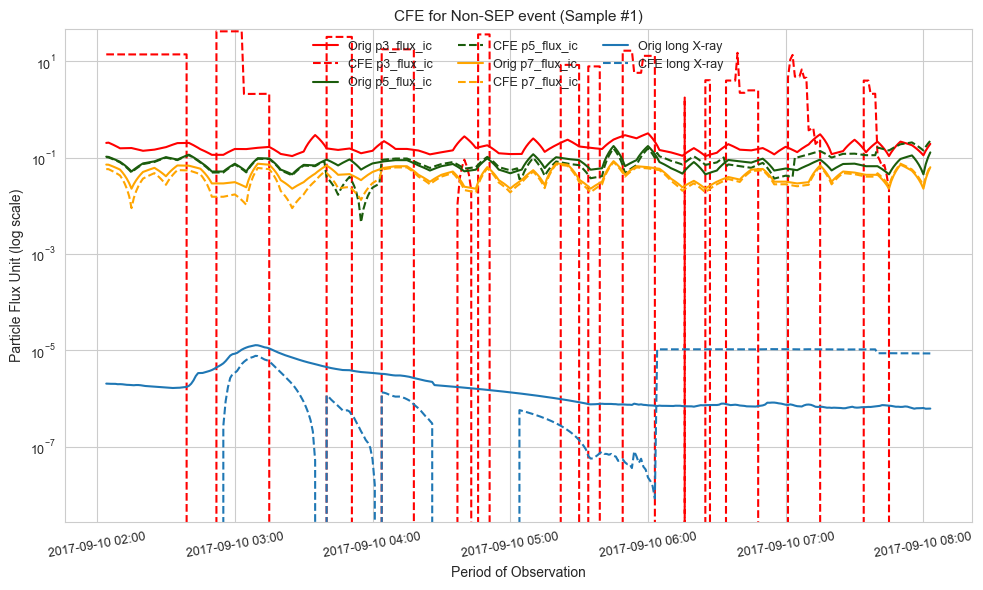

In [101]:
window_size = 10
CSV_DATA_DIR = "/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/raw/data/"
csv_path = os.path.join(CSV_DATA_DIR, query_ts2_filename)

fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")

# choose the CFE to display; loop if you like, or just pick one
cfe_idx = 0
sample_cfe = df_cfe_exp_genetic_2.iloc[cfe_idx]

# p3
flux_type = "p3_flux_ic"
df_obs, final_series_p3, original_p3, min_y_p3, max_y_p3 = get_pertubed_series(
    csv_path, sample_cfe, flux_type, header_list, 300, 660)
orig_p3 = original_p3
cf_p3 = pd.Series(final_series_p3)

# p5
flux_type = "p5_flux_ic"
df_obs1, final_series_p5, original_p5, min_y_p5, max_y_p5 = get_pertubed_series(
    csv_path, sample_cfe, flux_type, header_list, 300, 660)
orig_p5 = original_p5
cf_p5 = pd.Series(final_series_p5)

# p7
flux_type = "p7_flux_ic"
df_obs2, final_series_p7, original_p7, min_y_p7, max_y_p7 = get_pertubed_series(
    csv_path, sample_cfe, flux_type, header_list, 300, 660)
orig_p7 = original_p7
cf_p7 = pd.Series(final_series_p7)

# long mean
flux_type = "long"
df_obs3, final_series_long, original_long, min_y_l, max_y_l = get_pertubed_series(
    csv_path, sample_cfe, flux_type, header_list, 300, 660)
orig_l = original_long
cf_l = pd.Series(final_series_long)

# combine limits
ymin = min(min_y_p3, min_y_p5, min_y_p7, min_y_l)
ymax = max(max_y_p3, max_y_p5, max_y_p7, max_y_l)

# single axis plotting
ax.set_facecolor("white")
ax.plot(df_obs["time_stamp"], orig_p3, label="Orig p3_flux_ic", color="#FF0000")
ax.plot(df_obs["time_stamp"], cf_p3, label="CFE p3_flux_ic", color="#FF0000", ls="--")
ax.plot(df_obs1["time_stamp"], orig_p5, label="Orig p5_flux_ic", color="#1b5c0c")
ax.plot(df_obs1["time_stamp"], cf_p5, label="CFE p5_flux_ic", color="#1b5c0c", ls="--")
ax.plot(df_obs2["time_stamp"], orig_p7, label="Orig p7_flux_ic", color="#FFA500")
ax.plot(df_obs2["time_stamp"], cf_p7, label="CFE p7_flux_ic", color="#FFA500", ls="--")
ax.plot(df_obs3["time_stamp"], orig_l, label="Orig long X-ray", color="#1f77b4")
ax.plot(df_obs3["time_stamp"], cf_l, label="CFE long X-ray", color="#1f77b4", ls="--")

ax.set_yscale("log")
ax.set_ylim(ymin * 0.9, ymax * 1.1)
ax.set_xlabel("Period of Observation", fontsize=10)
ax.set_ylabel("Particle Flux Unit (log scale)", fontsize=10)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
plt.setp(ax.get_xticklabels(), rotation=10, ha="center", fontsize=9)
plt.setp(ax.get_yticklabels(), fontsize=9)
label_str = "SEP-Event" if class_label == 1 else "Non-SEP event"
ax.set_title(f"CFE for {label_str} (Sample #{cfe_idx+1})", fontsize=11)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.0), ncol=3, frameon=False, fontsize=9)


plt.tight_layout()
plt.show()


In [102]:
query_ts3_filename = '2003-11-20_18-08.csv'
query_instance3, class_label, predicted_label = get_query_instance(query_ts3_filename, combined_df, best_rf)

cfe_label = 0 if predicted_label[0] == 1 else 1

print(f"cfe_label: {cfe_label}")
cfe_exp = []
df_cfe_exp_genetic_3 = pd.DataFrame()
cfe_genetic = exp_genetic.generate_counterfactuals(
    query_instance2,  #multiple query instances can be provided as an input dataframe
    total_CFs=1,  # Number of counterfactual examples to generate
    desired_class=cfe_label,  #'opposite' #,  # Specify the desired class for a continuous target variable
    #permitted_range={'variable1': [20, 30], 'variable2': ['val1', 'val2']}
    # features_to_vary=top_k_features,
    # proximity_weight=pw,
    # diversity_weight=dw
    # feature_weights=sorted_normalized_weights_dict
)

cfe_genetic.visualize_as_dataframe(show_only_changes=True)
df_cfe_exp_genetic_3 = cfe_genetic.cf_examples_list[0].final_cfs_df


Target value for the query instance:
 0
Predicted value:
 [0]
cfe_label: 1


100%|██████████| 1/1 [00:00<00:00,  5.87it/s]

Query instance (original outcome : 0)


,long_mean_@[300:660],long_mean_@[396:636],long_mean_@[420:660],long_mean_@[480:660],long_mean_@[540:660],p3_flux_ic_mean_@[300:480],p3_flux_ic_mean_@[300:540],p3_flux_ic_mean_@[300:660],p3_flux_ic_mean_@[336:516],p3_flux_ic_mean_@[348:588],...,p5_flux_ic_mean_@[396:636],p5_flux_ic_mean_@[420:660],p5_flux_ic_mean_@[480:660],p5_flux_ic_mean_@[540:660],p5_flux_ic_mean_@[570:660],p5_flux_ic_mean_@[600:660],p7_flux_ic_mean_@[300:660],p7_flux_ic_mean_@[396:636],p7_flux_ic_mean_@[420:660],label
0,0.000002,0.000001,0.000001,7.684888e-07,7.037311e-07,0.156576,0.169427,0.16567,0.158692,0.164915,...,0.076208,0.076467,0.078986,0.071036,0.073907,0.073235,0.045335,0.044604,0.044382,0



Diverse Counterfactual set (new outcome: 1)


,long_mean_@[300:660],long_mean_@[396:636],long_mean_@[420:660],long_mean_@[480:660],long_mean_@[540:660],p3_flux_ic_mean_@[300:480],p3_flux_ic_mean_@[300:540],p3_flux_ic_mean_@[300:660],p3_flux_ic_mean_@[336:516],p3_flux_ic_mean_@[348:588],...,p5_flux_ic_mean_@[396:636],p5_flux_ic_mean_@[420:660],p5_flux_ic_mean_@[480:660],p5_flux_ic_mean_@[540:660],p5_flux_ic_mean_@[570:660],p5_flux_ic_mean_@[600:660],p7_flux_ic_mean_@[300:660],p7_flux_ic_mean_@[396:636],p7_flux_ic_mean_@[420:660],label
0,3.495001e-06,4.345161e-06,5.173e-06,6.84982e-06,1.017823e-05,0.163733333,0.170545831,0.195558339,0.171694443,0.174217507,...,0.076,0.091,0.096,0.106,0.112,0.139,0.0383,0.0392,0.0414,1.0


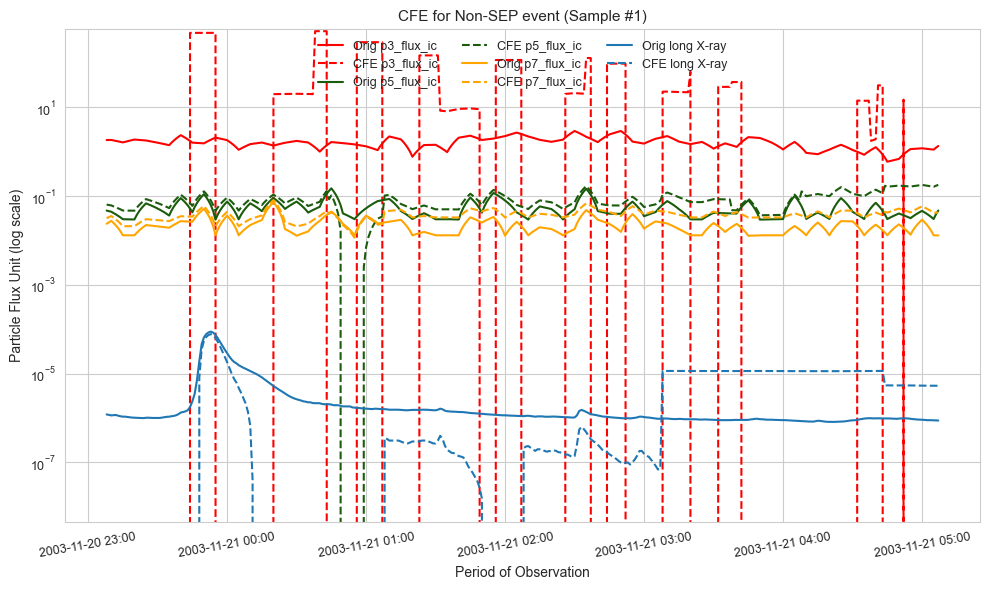

In [103]:
window_size = 10
CSV_DATA_DIR = "/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/raw/data/"
csv_path = os.path.join(CSV_DATA_DIR, query_ts3_filename)

fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")

# choose the CFE to display; loop if you like, or just pick one
cfe_idx = 0
sample_cfe = df_cfe_exp_genetic_3.iloc[cfe_idx]

# p3
flux_type = "p3_flux_ic"
df_obs, final_series_p3, original_p3, min_y_p3, max_y_p3 = get_pertubed_series(
    csv_path, sample_cfe, flux_type, header_list, 300, 660)
orig_p3 = original_p3
cf_p3 = pd.Series(final_series_p3)

# p5
flux_type = "p5_flux_ic"
df_obs1, final_series_p5, original_p5, min_y_p5, max_y_p5 = get_pertubed_series(
    csv_path, sample_cfe, flux_type, header_list, 300, 660)
orig_p5 = original_p5
cf_p5 = pd.Series(final_series_p5)

# p7
flux_type = "p7_flux_ic"
df_obs2, final_series_p7, original_p7, min_y_p7, max_y_p7 = get_pertubed_series(
    csv_path, sample_cfe, flux_type, header_list, 300, 660)
orig_p7 = original_p7
cf_p7 = pd.Series(final_series_p7)

# long mean
flux_type = "long"
df_obs3, final_series_long, original_long, min_y_l, max_y_l = get_pertubed_series(
    csv_path, sample_cfe, flux_type, header_list, 300, 660)
orig_l = original_long
cf_l = pd.Series(final_series_long)

# combine limits
ymin = min(min_y_p3, min_y_p5, min_y_p7, min_y_l)
ymax = max(max_y_p3, max_y_p5, max_y_p7, max_y_l)

# single axis plotting
ax.set_facecolor("white")
ax.plot(df_obs["time_stamp"], orig_p3, label="Orig p3_flux_ic", color="#FF0000")
ax.plot(df_obs["time_stamp"], cf_p3, label="CFE p3_flux_ic", color="#FF0000", ls="--")
ax.plot(df_obs1["time_stamp"], orig_p5, label="Orig p5_flux_ic", color="#1b5c0c")
ax.plot(df_obs1["time_stamp"], cf_p5, label="CFE p5_flux_ic", color="#1b5c0c", ls="--")
ax.plot(df_obs2["time_stamp"], orig_p7, label="Orig p7_flux_ic", color="#FFA500")
ax.plot(df_obs2["time_stamp"], cf_p7, label="CFE p7_flux_ic", color="#FFA500", ls="--")
ax.plot(df_obs3["time_stamp"], orig_l, label="Orig long X-ray", color="#1f77b4")
ax.plot(df_obs3["time_stamp"], cf_l, label="CFE long X-ray", color="#1f77b4", ls="--")

ax.set_yscale("log")
ax.set_ylim(ymin * 0.9, ymax * 1.1)
ax.set_xlabel("Period of Observation", fontsize=10)
ax.set_ylabel("Particle Flux Unit (log scale)", fontsize=10)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
plt.setp(ax.get_xticklabels(), rotation=10, ha="center", fontsize=9)
plt.setp(ax.get_yticklabels(), fontsize=9)
label_str = "SEP-Event" if class_label == 1 else "Non-SEP event"
ax.set_title(f"CFE for {label_str} (Sample #{cfe_idx+1})", fontsize=11)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.0), ncol=3, frameon=False, fontsize=9)


plt.tight_layout()
plt.show()
